## Grammarly Data Exercise

This project uses the log data collected from an app for the month of February 2016. When the app is opened by a user, the app pings the analytics system. A user may ping multiple times in a day. The goal of this project is to analyze the data to show the daily active users over the month, calculate the daily retention curve for the cohort of users who used the app for the first time on specific dates, and determine if there are any differences in usage based on where the users came from. I utilized NumPy, Pandas, Matplotlib and Seaborn libraries in Python to perform cohort analysis, visualized the insights and provided business recommendations.

## Importing the necessary packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
%matplotlib inline

## Data

In [3]:
data = pd.read_json('data.json')

In [4]:
# first 5 rows of the dataset

data.head()

,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program
3,2016-02-29,2016-02-29 08:00:03.129,11l0tD2wFPFO,False,None
4,2016-02-29,2016-02-29 08:00:03.610,56429432,False,None


In [5]:
# the shape of the dataset

data.shape

(4823567, 5)

## Data pre-processing

Now let us understand the data with some summary statistics

In [6]:
# basic description of the dataset

data.describe()

,date,timestamp,uid,isFirst,utmSource
count,4823567,4823567,4823567,4823567,3149181
unique,29,4802369,246840,2,52
top,2016-02-29 00:00:00,2016-02-25 19:46:44.202000,vwLJO2uDWrXr,False,Biznesowe+Rewolucje
freq,194747,18,2853,4736834,1780384
first,2016-02-01 00:00:00,2016-02-01 08:00:01.230000,NaN,NaN,NaN
last,2016-02-29 00:00:00,2016-03-01 07:59:58.557000,NaN,NaN,NaN


We shall now create a new column that contains the information about the 'time' at which a user 'ping'ed the system.

In [7]:
data['time'] = [d.time() for d in data['timestamp']]

It would also be helpful to create a new column that contains the information about the day of the week in which a user 'ping'ed the system.

In [8]:
data['dayOfWeek'] = [d.day_name() for d in data['date']]

In [9]:
data['dayOfWeek'] = pd.Categorical(data['dayOfWeek'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

Creating sessions of 'morning', 'afternoon', 'evening', 'night' based on the time at which the user 'ping'ed

In [10]:
data=data.assign(session=pd.cut(data.timestamp.dt.hour,
                            [0,6,12,18,23],
                            labels=['Night','Morning','Afternoon','Evening'],
                            include_lowest=True))


In [11]:
# checking for null values

data.isnull().sum()

date               0
timestamp          0
uid                0
isFirst            0
utmSource    1674386
time               0
dayOfWeek          0
session            0
dtype: int64

We can see that the column 'utmSource' has about 1674386 NULL values. However, since the coulmn 'utmSource' denotes the sources from which the traffic to this website has come, instead of dropping these rows, we can convert the NULL values in to "unknown" source by creating a new columnn called 'source'.

In [12]:
data['source'] = data['utmSource'].fillna('unknown')

In [13]:
data.isnull().sum()

date               0
timestamp          0
uid                0
isFirst            0
utmSource    1674386
time               0
dayOfWeek          0
session            0
source             0
dtype: int64

We can see that the 'source' column does not have any NULL values.

In the data, it is mentioned that in a 'uid', if the string is purely numeric, this means the user is registered, otherwise it's a device id. In order to differentiate between a registered and an un-registered user, we shall create a mapping function that maps the 'uid' as a registered (i.e. "1") or non-registered user (i.e. "0")

In [14]:
# defining a function to map the 'uid' as numeric or non-numeric
# 1 denotes numeric and 0 denotes non-numeric

def func(x):
    if x.isnumeric():
        return 1
    else:
        return 0

In [15]:
# making a 'registered' column based on whether the 'uid' is numeric or not
# if the 'uid' is numeric, then it is a registered user or else not

data['registered'] = list(map(func,data['uid']))

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4823567 entries, 0 to 4823566
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   timestamp   datetime64[ns]
 2   uid         object        
 3   isFirst     bool          
 4   utmSource   object        
 5   time        object        
 6   dayOfWeek   category      
 7   session     category      
 8   source      object        
 9   registered  int64         
dtypes: bool(1), category(2), datetime64[ns](2), int64(1), object(4)
memory usage: 271.4+ MB


## Final dataset

In [17]:
# new final dataset

data.head()

,date,timestamp,uid,isFirst,utmSource,time,dayOfWeek,session,source,registered
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje,08:00:01.255000,Monday,Morning,Biznesowe+Rewolucje,0
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje,08:00:01.556000,Monday,Morning,Biznesowe+Rewolucje,0
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program,08:00:01.770000,Monday,Morning,program,1
3,2016-02-29,2016-02-29 08:00:03.129,11l0tD2wFPFO,False,None,08:00:03.129000,Monday,Morning,unknown,0
4,2016-02-29,2016-02-29 08:00:03.610,56429432,False,None,08:00:03.610000,Monday,Morning,unknown,1


In [18]:
# shape of the final dataset

data.shape

(4823567, 10)

## Question 1: Show the daily active users over the month, including all users. A user is considered active if they pinged at least once on a given day.

Let us begin with grouping the dates and counting the unique users on each date.

In [94]:
# daily active users

dau = data.groupby('date')['uid'].nunique()
dau

date
2016-02-01    112504
2016-02-02    112317
2016-02-03    113062
2016-02-04    111098
2016-02-05    102420
2016-02-06     94807
2016-02-07    104175
2016-02-08    114802
2016-02-09    115859
2016-02-10    117113
2016-02-11    115290
2016-02-12    106132
2016-02-13     97788
2016-02-14    106158
2016-02-15    119409
2016-02-16    120874
2016-02-17    122053
2016-02-18    120374
2016-02-19    112452
2016-02-20    104665
2016-02-21    120306
2016-02-22    130017
2016-02-23    131707
2016-02-24    131947
2016-02-25    130334
2016-02-26    120658
2016-02-27    112789
2016-02-28    128096
2016-02-29    138644
Name: uid, dtype: int64

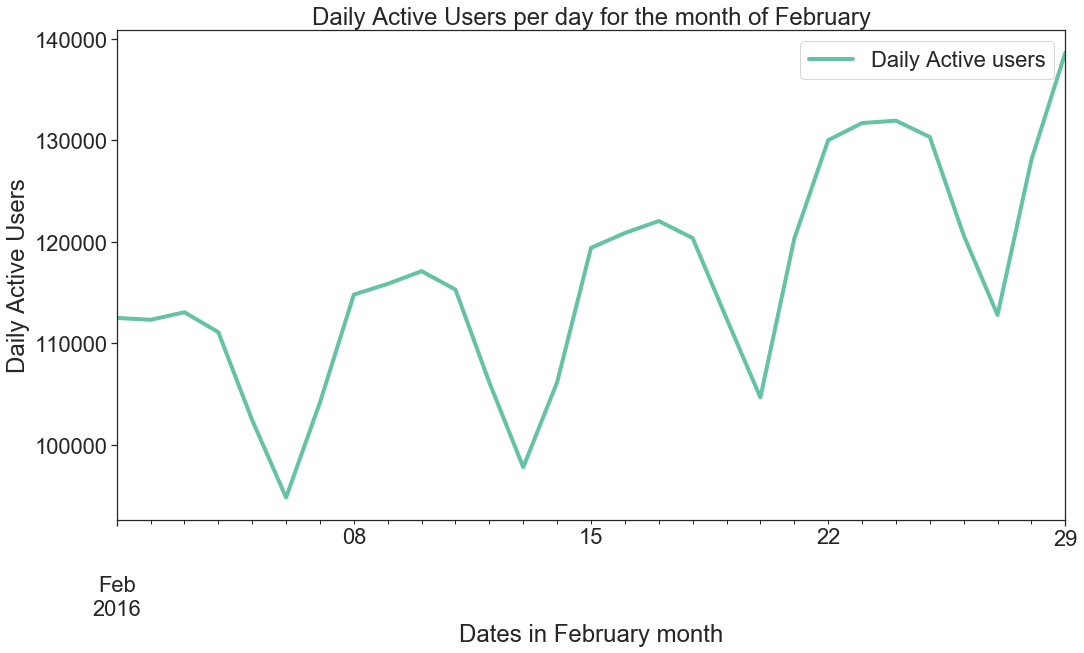

In [95]:
# number of daily active users over the month of February, including all users

sns.set(font_scale=2,rc={'figure.figsize':(17, 9)})
sns.set_palette("Set2",3)
sns.set_style("ticks")
fig, ax = plt.subplots()
dau.plot(ax=ax, linewidth=4, label='Daily Active users')
plt.xlabel("Dates in February month")
plt.ylabel("Daily Active Users")
plt.title("Daily Active Users per day for the month of February")
plt.legend();

From the above chart, we can see that, although the Daily Active Users (DAU) have been steadily increasing over the month of February, there seems to be a cyclic pattern of increases and dips in the number of unique users of the app over the month. The number of users seems to peak around the start of the week (on Mondays) and dip around the weekeends (especially on Saturdays).

In order to explore this further we shall further dwell into the number of visits to the app on different days of the week.

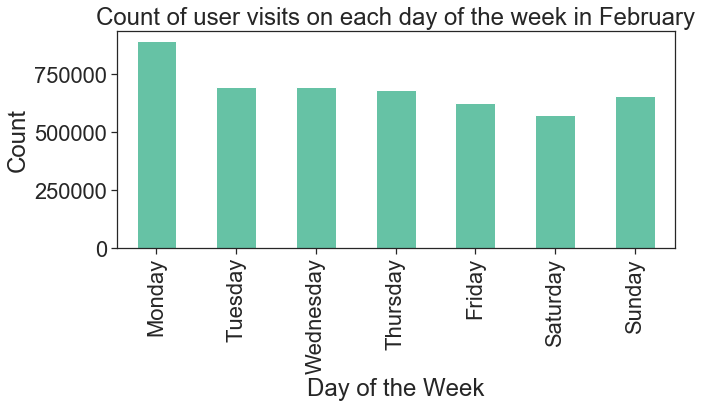

In [96]:
# plotting the count of user visits on each day of the week in February

ax = data.groupby(['dayOfWeek']).count()['uid'].plot(kind = 'bar', figsize = (10,4), 
                            title = 'Count of user visits on each day of the week in February')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Count');

The metric being tracked here is the count of users on each day of the week over the month of February.
From the above bar graph, it is clear that Monday gets the most number of visitors and Saturday gets the least number of visitors.

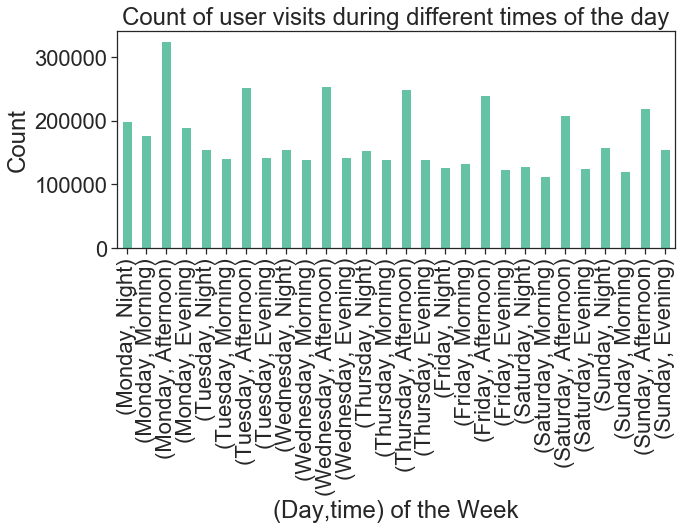

In [97]:
# plotting the count of user visits during different times of the day

ax = data.groupby(['dayOfWeek','session']).count()['uid'].plot(kind = 'bar', figsize = (10,4), 
                            title = 'Count of user visits during different times of the day')
ax.set_xlabel('(Day,time) of the Week')
ax.set_ylabel('Count');

The metric is count of users over different times of the day and the above bar graph shows that Afternoons garner the most number of visitors consistently.

### Business recommendation:

If the assumption is that, our app is a social media app such as 'Facebook' or 'Instagram' where users log in to connect with people, it would be a good idea to run the most renevue generating Ads during Monday afternoons since that has a better chance of the Ad being watched and recognized by the users. And providing promotional offers during Saturdays could increase app interaction by a user.

Now we shall compare the Daily Active Users with that of the users who logged in to the app for the first time in February

In [98]:
# users who started using the app in February 2016
data_feb_unique = data[data['isFirst']==True]['uid'].unique() 
data_feb_users = data[(data['uid'].isin(data_feb_unique))]


# daily active users (DAU) for users who started  using the app in February 2016
dau_feb= data_feb_users.groupby(['date']).nunique()['uid']
dau_feb

date
2016-02-01     3071
2016-02-02     4805
2016-02-03     6279
2016-02-04     7485
2016-02-05     7792
2016-02-06     8134
2016-02-07     9988
2016-02-08    12121
2016-02-09    13427
2016-02-10    14943
2016-02-11    16043
2016-02-12    15650
2016-02-13    15312
2016-02-14    17695
2016-02-15    21169
2016-02-16    21221
2016-02-17    23183
2016-02-18    24214
2016-02-19    23446
2016-02-20    23295
2016-02-21    27796
2016-02-22    30885
2016-02-23    32635
2016-02-24    34043
2016-02-25    34737
2016-02-26    32910
2016-02-27    32094
2016-02-28    37289
2016-02-29    41063
Name: uid, dtype: int64

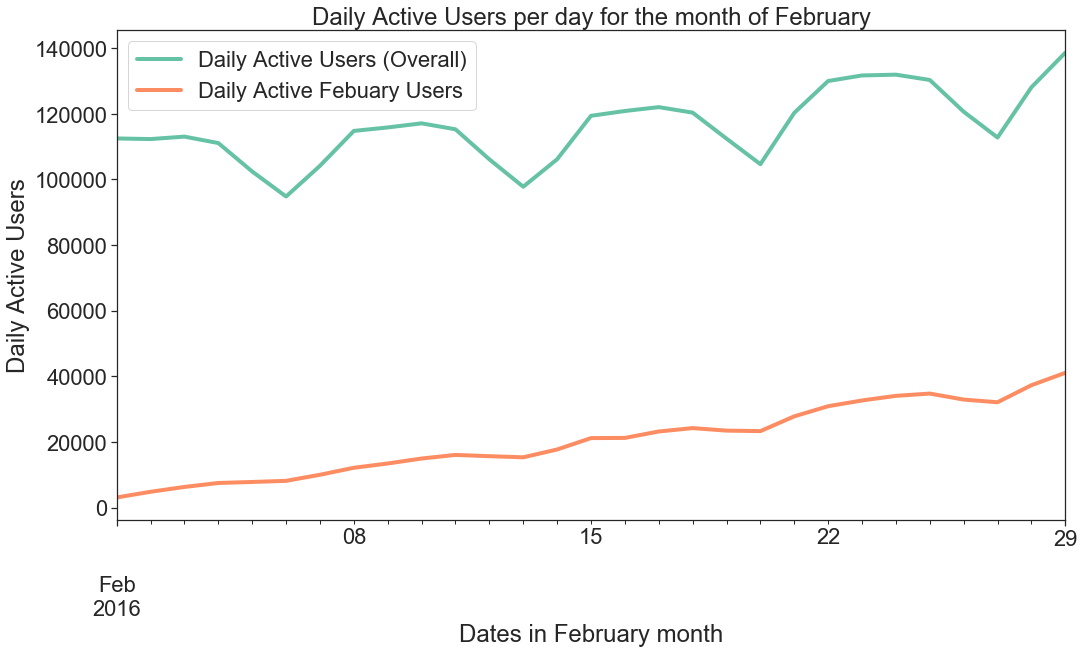

In [99]:
# number of daily active users over the month of February, including all users
# along with the users who started using the app in February

sns.set(font_scale=2,rc={'figure.figsize':(17, 9)})
sns.set_palette("Set2",3)
sns.set_style("ticks")
fig, ax = plt.subplots()
dau.plot(ax=ax, linewidth=4, label='Daily Active Users (Overall)')
dau_feb.plot(ax=ax, linewidth=4, label='Daily Active Febuary Users')
plt.xlabel("Dates in February month")
plt.ylabel("Daily Active Users")
plt.title("Daily Active Users per day for the month of February")
plt.legend();

We can notice from the above comparison that the Daily Active Users of the app for the users who started the app in February is steadily increasing denoting a positive growth for the app over the month of February.

Now we shall compare the Daily Active Users of the app with respect to the users who are registered as opposed to the users who are not registered.

In [100]:
# users who are registered

data_users_registered = data[data['registered']== 1] 
data_reg = data_users_registered.groupby(['date']).nunique()['uid']
data_reg

date
2016-02-01     90146
2016-02-02     90276
2016-02-03     90931
2016-02-04     89500
2016-02-05     82596
2016-02-06     76566
2016-02-07     84426
2016-02-08     92824
2016-02-09     93816
2016-02-10     95003
2016-02-11     93689
2016-02-12     86184
2016-02-13     79476
2016-02-14     86269
2016-02-15     97200
2016-02-16     98217
2016-02-17     99317
2016-02-18     98158
2016-02-19     91678
2016-02-20     85544
2016-02-21     98509
2016-02-22    106172
2016-02-23    107759
2016-02-24    108126
2016-02-25    106695
2016-02-26     98663
2016-02-27     92439
2016-02-28    105117
2016-02-29    113479
Name: uid, dtype: int64

In [101]:
# users who are non-registered

data_users_non_registered = data[data['registered']== 0] 
data_non_reg = data_users_non_registered.groupby(['date']).nunique()['uid']
data_non_reg

date
2016-02-01    22358
2016-02-02    22041
2016-02-03    22131
2016-02-04    21598
2016-02-05    19824
2016-02-06    18241
2016-02-07    19749
2016-02-08    21978
2016-02-09    22043
2016-02-10    22110
2016-02-11    21601
2016-02-12    19948
2016-02-13    18312
2016-02-14    19889
2016-02-15    22209
2016-02-16    22657
2016-02-17    22736
2016-02-18    22216
2016-02-19    20774
2016-02-20    19121
2016-02-21    21797
2016-02-22    23845
2016-02-23    23948
2016-02-24    23821
2016-02-25    23639
2016-02-26    21995
2016-02-27    20350
2016-02-28    22979
2016-02-29    25165
Name: uid, dtype: int64

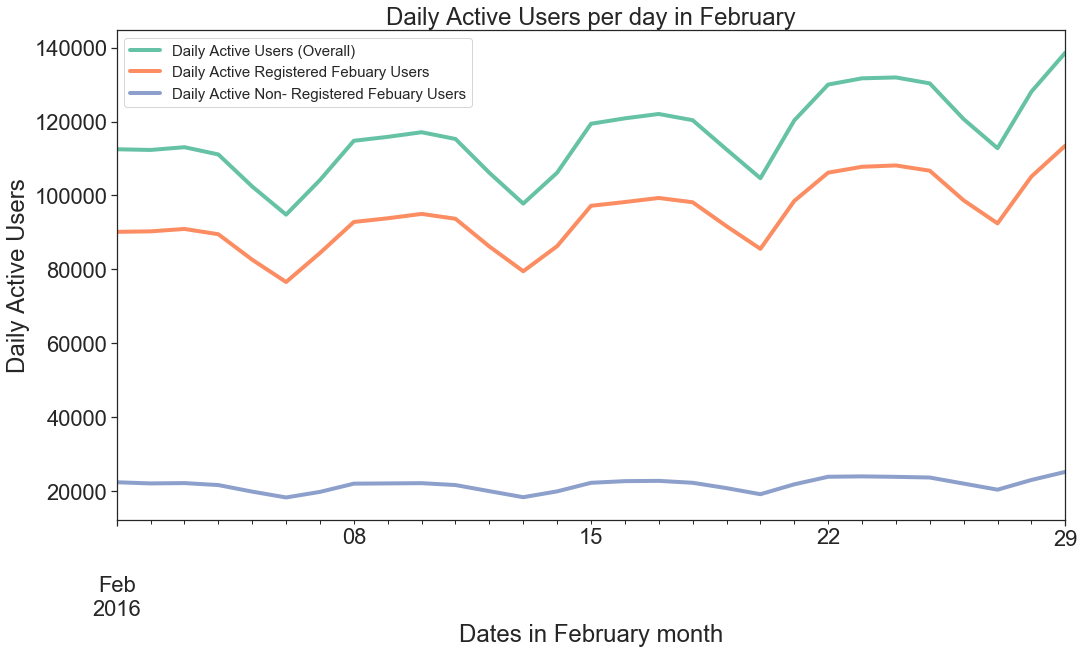

In [102]:
# number of daily active users over the month of February, including all users
# along with the users who started using the app in February

sns.set(font_scale=2,rc={'figure.figsize':(17, 9)})
sns.set_palette("Set2",3)
sns.set_style("ticks")
fig, ax = plt.subplots()
dau.plot(ax=ax, linewidth=4, label='Daily Active Users (Overall)')
data_reg.plot(ax=ax, linewidth=4, label='Daily Active Registered Febuary Users')
data_non_reg.plot(ax=ax, linewidth=4, label='Daily Active Non- Registered Febuary Users')
plt.xlabel("Dates in February month")
plt.ylabel("Daily Active Users")
plt.title("Daily Active Users per day in February")
plt.legend(loc='upper left',prop={'size': 15});

From the above line graph, we can see that the number of registered users using the app is much higher than the number of non-registered users using the app. Also, the non-registered users also follow a similar trend of the registered users with dips over weekends and peak activity at the start of the week.

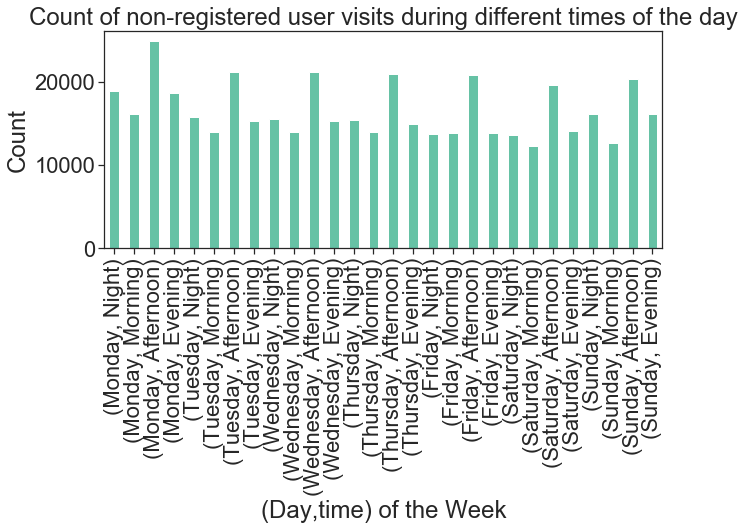

In [103]:
# plotting the count of non-registered user visits during different times of the day

ax = data[data['registered'] == 0].groupby(['dayOfWeek','session']).nunique()['uid'].plot(kind = 'bar', figsize = (10,4), 
                            title = 'Count of non-registered user visits during different times of the day')
ax.set_xlabel('(Day,time) of the Week')
ax.set_ylabel('Count');

From the above bar graph, we can see that the number of non-registered users using the app is much higher during the afernoons. 

## Business Recommendation: 
We may start considering issuing promotional offers to register in the app during afternoons to convert these non-registered users into registered users for a better conversion rate.

## Question 2: Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th. Also, show the number of users from each cohort. 

## Daily retention curve is defined as the % of users from the cohort, who used the product that day.


In order to calculate the daily retention curve for users who used the app for the first time on specific cohort dates, we need to follow a two step process

1. Create cohorts for all users who started using the app for the first time on those specific dates
2. And then, for each of the days following those 'specific dates' (the dates chosen for cohort analysis), we need to calculate the daily user retention percentage by considering those 'specific dates' as the start dates.

In [104]:
# defining a function to create a cohort of all users who started using the app for the first time on those specific dates

def dailyCohort(df,date):
    cohort=df[(df['isFirst']== True) & (df['date'] == date)]
    num_users= cohort['uid'].nunique()
    print("Number of distinct users on %s:" %date, num_users)
    cohort_list= cohort['uid'].unique()
    cohort_df= df[df['uid'].isin(cohort_list)]
    cohort_daily_data=pd.DataFrame((cohort_df.groupby(['date']).nunique()['uid']/num_users*100).round(2))
    return cohort_daily_data

In [105]:
dates=['2016-2-4', '2016-2-10', '2016-2-14']
cohort_04= dailyCohort(data, '2016-02-04')
cohort_10= dailyCohort(data, '2016-02-10')
cohort_14= dailyCohort(data, '2016-02-14')

cohort_04['CohortStartDate']= '2016-02-04'
cohort_10['CohortStartDate']= '2016-02-10'
cohort_14['CohortStartDate']= '2016-02-14'

cohort_04.insert(0, 'day', range(1, 1 + len(cohort_04)))
cohort_10.insert(0, 'day', range(1, 1 + len(cohort_10)))
cohort_14.insert(0, 'day', range(1, 1 + len(cohort_14)))

percentage_list=[cohort_04, cohort_10, cohort_14]
count_of_cohort= pd.concat(percentage_list)
pivoted_cohort= count_of_cohort.pivot(index='CohortStartDate', 
                                 columns='day', values='uid')

Number of distinct users on 2016-02-04: 2735
Number of distinct users on 2016-02-10: 3129
Number of distinct users on 2016-02-14: 2761


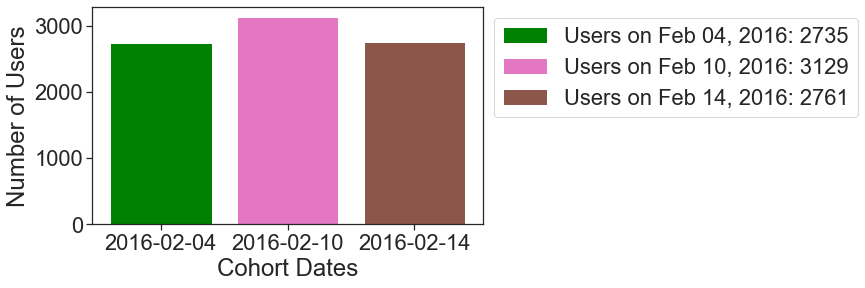

In [106]:
#  count of the number of users for each cohort
plt.figure(figsize=(7,4))
plt.bar('2016-02-04',2735, label='Users on Feb 04, 2016: 2735', color='Green')
plt.bar('2016-02-10',3129, label='Users on Feb 10, 2016: 3129', color='tab:pink')
plt.bar('2016-02-14',2761, label='Users on Feb 14, 2016: 2761', color='tab:brown')

plt.xlabel('Cohort Dates')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Number of Users');

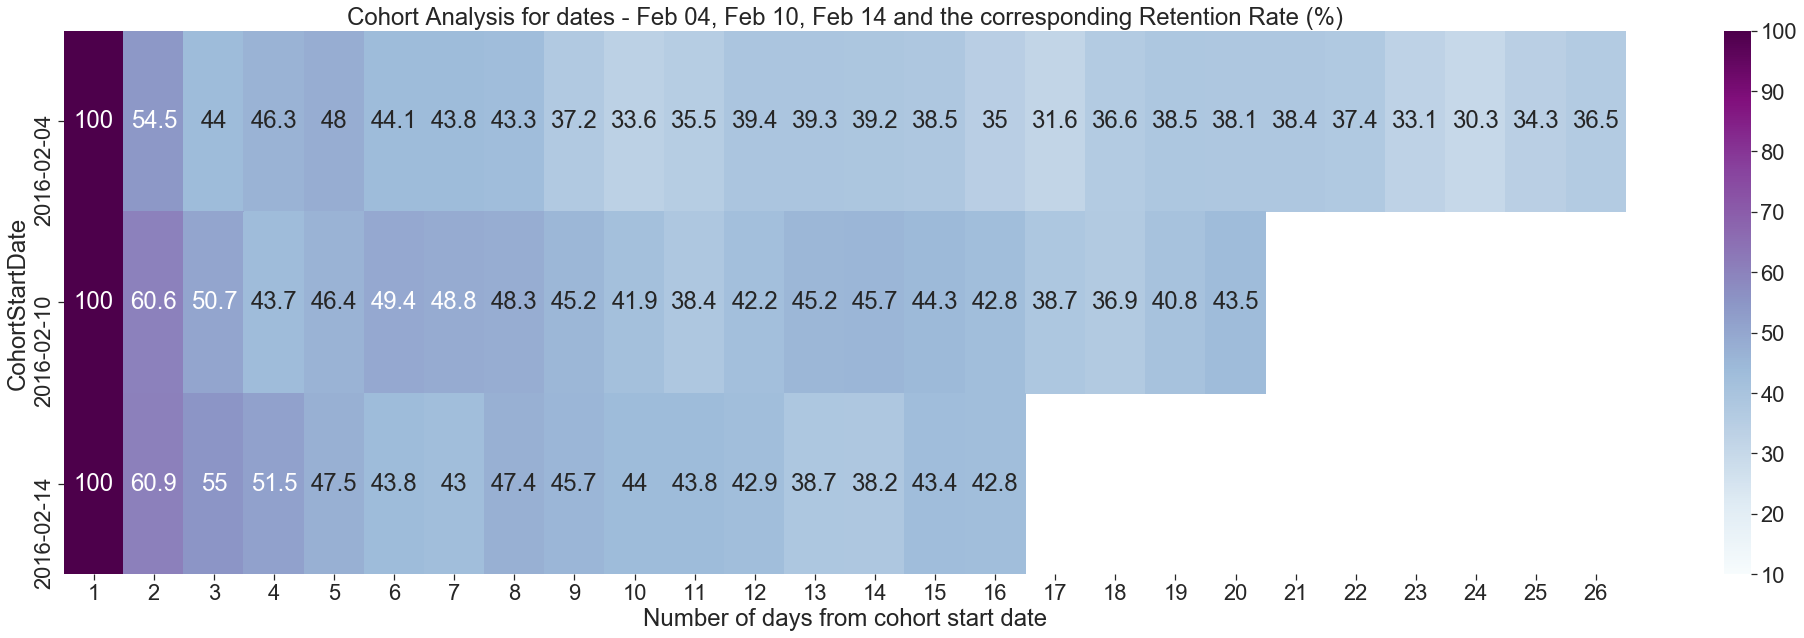

In [107]:
# plotting a heat map of the retention rates

plt.figure(figsize = (35,10))
plt.title('Cohort Analysis for dates - Feb 04, Feb 10, Feb 14 and the corresponding Retention Rate (%)')
sns.heatmap(data = pivoted_cohort, 
            annot = True,
            cbar = True,
            fmt='0.3g',
            vmin = 10,
            vmax = 100,
            cmap = "BuPu")
plt.xlabel('Number of days from cohort start date')
plt.show()


## Insights

From the above heatmap, we can see that within the first one day, the retention percentage of users comes down more than 40% and keep decreasing gradually. 

However, there seems to be a pattern in which this happens.
For instance, observing the February 4th Cohort, the retention percentage increases briefly on the 5th, 12th and 19th - all of which corresponds to Mondays and then the retention percentage slowly starts decreasing through the week only to again increase over the start of the next week. This patterns seems to follow for the February 10th Cohort as well.

However, for the people who joined the app on the February 14th, there seems to be an on the 8th day (Feb 21st) which is a Sunday and then it gradually decreases through the week and then increases again on the 15th day which is also on Sunday (Feb 28th).

The difference in the nature of app usage between the Feb 4th and Feb 10th cohorts as compared to the Feb 14th cohort could also be attributed to the fact that Feb 14 is a Valentines Day (also happens to be my birthday lol :P). Hence, if this app is anything related to online social interaction such as Facebook or Instagram, then it makes sense that people would use the app more on these kind of celebratory days and the cohort analysis for these kind of days must be different from the regular weekends or holidays. 

In [108]:
def daily_Retention_curve(df,date):
    cohort=df[(df['isFirst']== True) & (df['date'] == date)]
    num_users= cohort['uid'].nunique()
    print("Number of distinct users on %s:" %date, num_users)
    cohort_list= cohort['uid'].unique()
    cohort_df= df[df['uid'].isin(cohort_list)]
    cohort_daily_data=(cohort_df.groupby(['date']).nunique()['uid']/num_users)
    return cohort_daily_data

Number of distinct users on 2016-02-04: 2735
Number of distinct users on 2016-02-10: 3129
Number of distinct users on 2016-02-14: 2761


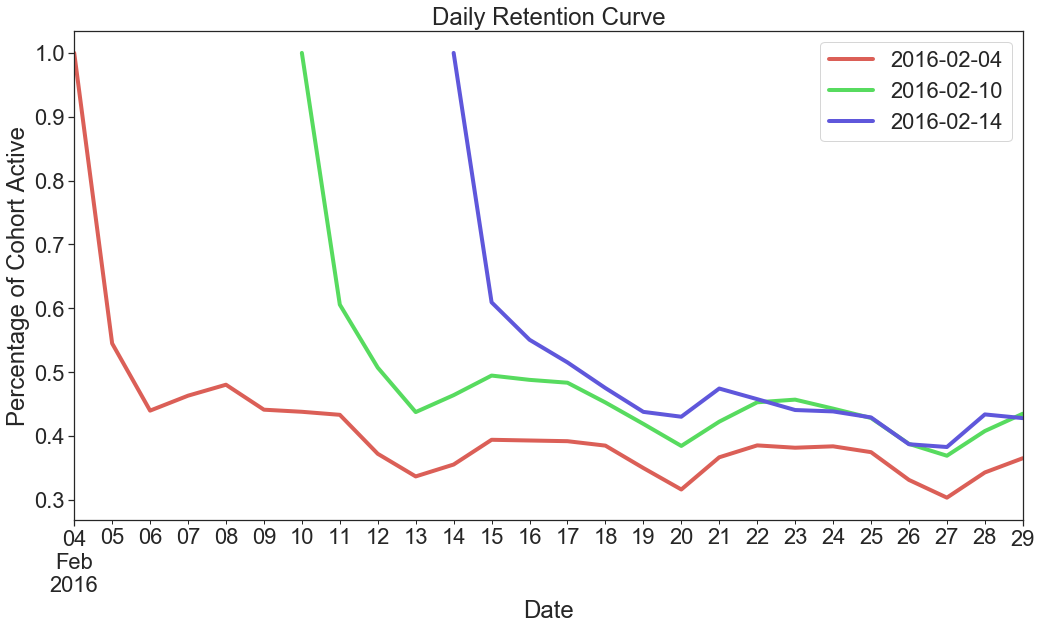

In [109]:
sns.set_palette("hls",3)
fig, ax = plt.subplots(figsize=(17,9))
dates=['2016-02-04', '2016-02-10', '2016-02-14']
for date in dates:
    retention_date=daily_Retention_curve(data,date)
    retention_date.plot(ax=ax, linewidth='4', label= date)
plt.title('Daily Retention Curve')
plt.xlabel('Date')
plt.ylabel('Percentage of Cohort Active')
plt.legend()
plt.show()

Based on the retention curve for the cohort dates Febuary 4th and Febuary 10th, we can notice a considerable drop in the retention percentage with in the first two days. The retention percentage increases a little bit after the first 2 days and slowly decreases after that and the second significant drop can be found on approximately the 10th day after using the app. The two curves for these days surprisingly follows a similar pattern through-out the month.

The retention curve for the February 14th however, has a significant drop on the first day and then keeps decreasing until the 20th February and then increases briefly on the February 21st only to decrease gradually again. 


## Business Recommendation:

Some of the ways that could be employed to improve retention rate is:
1. We may ask about the users' general interest during the first login so that we can use this information to send out a personalized push notifications (during the afternoons as we found out earlier to increase the chances of the user seeing the notification) roughly around the 10th day and 20th day since joining.
2. We could look into having an easy and efficient onboarding process.
3. Offer perks to most engaged users in order to increase the customer loyalty and improve the word-of-mouth publicity of the app.
4. Dig deeper into exactly which active page of the app the user was present when he stopped using the app. This gives us insights into the different pages of the app that results in user drop out. We can use this information to improve the engagement experience of the app, thereby increasing app activity.

## Question 3: Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?

Now let us take a closer look into the different unique sources a user has come from.

In [110]:
data['source'].unique()

array(['Biznesowe+Rewolucje', 'program', 'unknown', 'answers',
       'shmoop_left', 'twitter', 'dict', 'other', 'MosaLingua+FR',
       'facebook', 'salesmanago', 'MembershipCancellation', 'placement',
       'handbook', 'Grub+Street', 'youtube',
       'Just-In-Time+Travels+Newsletter', 'Facebook_org', 'tapjoy',
       'Book+Quote', 'contenthub', 'liveintent', 'blog', 'Blog_org',
       'bing', 'LinkedIn_org', 'google', 'Wise+Ink+Master+Email+List',
       'Bing', 'Twitter_org', 're:+charity', 'nettedbythewebbys',
       "Sarah+Doody's+UX+Notebook", 'Pre-quote+List', 'facebook.com',
       'email-sendgrid', 'sendgrid.com', 'shmoop_logo', 'SummerInvite',
       'TrialIntro', 'digg', 'outbrain', 'brand', 'cafemom.com',
       'GPlus_org', 'shmoop_right', 'gsp', 'Sticky Blogging Secrets',
       'pandora', 'taboola', 'blogger_outreach', 'display', 'card'],
      dtype=object)

In [111]:
data['source'].nunique()

53

We may notice that there are a few sources such as 'shmoop_logo', 'shmoop_right', 'shmoop_left' that should most probably belong to the different entry points of the same source 'shmoop'. Hence, we shall combine the sources such as these into a single source

In [112]:
data['source']= data['source'].str.lower()
np.sort(data['source'].unique())

array(['answers', 'bing', 'biznesowe+rewolucje', 'blog', 'blog_org',
       'blogger_outreach', 'book+quote', 'brand', 'cafemom.com', 'card',
       'contenthub', 'dict', 'digg', 'display', 'email-sendgrid',
       'facebook', 'facebook.com', 'facebook_org', 'google', 'gplus_org',
       'grub+street', 'gsp', 'handbook',
       'just-in-time+travels+newsletter', 'linkedin_org', 'liveintent',
       'membershipcancellation', 'mosalingua+fr', 'nettedbythewebbys',
       'other', 'outbrain', 'pandora', 'placement', 'pre-quote+list',
       'program', 're:+charity', 'salesmanago',
       "sarah+doody's+ux+notebook", 'sendgrid.com', 'shmoop_left',
       'shmoop_logo', 'shmoop_right', 'sticky blogging secrets',
       'summerinvite', 'taboola', 'tapjoy', 'trialintro', 'twitter',
       'twitter_org', 'unknown', 'wise+ink+master+email+list', 'youtube'],
      dtype=object)

In [113]:
data['source'] = data['source'].str.replace('blog.*', 'blog', regex=True)
data['source'] = data['source'].str.replace('facebook.*', 'facebook', regex=True)
data['source'] = data['source'].str.replace('gplus.*', 'google', regex=True)
data['source'] = data['source'].str.replace('shmoop.*', 'shmoop', regex=True)
data['source'] = data['source'].str.replace('twitter.*', 'twitter', regex=True)

In [114]:
data['source'].unique()

array(['biznesowe+rewolucje', 'program', 'unknown', 'answers', 'shmoop',
       'twitter', 'dict', 'other', 'mosalingua+fr', 'facebook',
       'salesmanago', 'membershipcancellation', 'placement', 'handbook',
       'grub+street', 'youtube', 'just-in-time+travels+newsletter',
       'tapjoy', 'book+quote', 'contenthub', 'liveintent', 'blog', 'bing',
       'linkedin_org', 'google', 'wise+ink+master+email+list',
       're:+charity', 'nettedbythewebbys', "sarah+doody's+ux+notebook",
       'pre-quote+list', 'email-sendgrid', 'sendgrid.com', 'summerinvite',
       'trialintro', 'digg', 'outbrain', 'brand', 'cafemom.com', 'gsp',
       'sticky blog', 'pandora', 'taboola', 'display', 'card'],
      dtype=object)

In [115]:
data['source'].nunique()

44

We have reduced the number of unique traffic sources from 53 to 44. However, there are still so many sources from which the users came from. We shall now look into the count of unique users from each of the source.

In [116]:
# total number of unique users from each of the different sources

pd.DataFrame(data.groupby(['source']).nunique()['uid']).sort_values(by=['uid'])

,uid
source,
summerinvite,1
gsp,1
sarah+doody's+ux+notebook,1
brand,1
cafemom.com,1
card,1
sendgrid.com,1
taboola,1
display,1


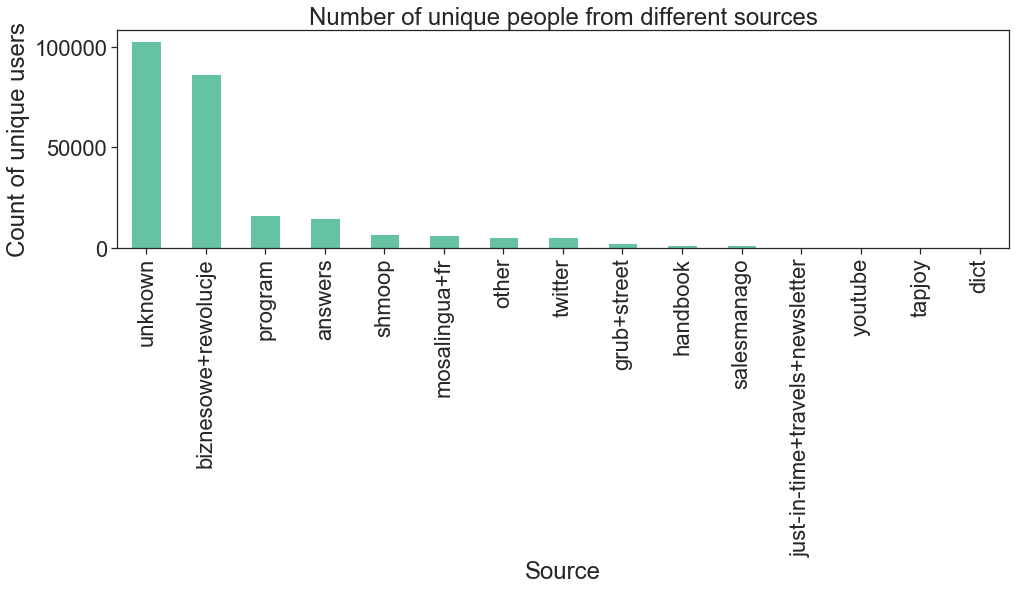

In [127]:
# total number of unique users from each of the different sources 

ax = data.groupby('source')['uid'].nunique().sort_values(ascending=False).tail(35).plot(kind = 'bar', figsize = (16,4),
                                                title = 'Number of unique people from different sources' )
ax.set_xlabel('Source')
ax.set_ylabel('Count of unique users');

By examining the above bar graph that shows the unique users from different sources, we can notice that around 30 unique sources had contributed less than 300 unique users per source which accounts for just about 0.2% of the total unique users. It makes sense to combine them into 'other' for simplifying our analysis.

In [118]:
grouped_sources = pd.DataFrame(data.groupby(['source']).nunique()['uid']).sort_values(by=['uid'])

# merge the traffic sources with less than 300 unique users to 'others'

small_sources = grouped_sources[grouped_sources['uid']<300].index.tolist()
for x in small_sources:
    data['source']=data['source'].str.replace(x,'other', regex=False)

In [119]:
data.source.unique()

array(['biznesowe+rewolucje', 'program', 'unknown', 'answers', 'shmoop',
       'twitter', 'dict', 'other', 'mosalingua+fr', 'salesmanago',
       'handbook', 'grub+street', 'youtube',
       'just-in-time+travels+newsletter', 'tapjoy'], dtype=object)

In [120]:
data.source.nunique()

15

Now we have reduced the traffic sources from 52 to 15.

We need to also look into whether a 'uid' has come from more than one traffic source.

In [121]:
number_of_sources = data.groupby(['uid'])['source'].nunique()
multiple_sources = np.sum(number_of_sources>1)
multiple_sources

4058

In [122]:
multiple_sources_fraction = np.sum(number_of_sources>1) / data['uid'].nunique()
multiple_sources_fraction

0.016439799060119917

Hence, there are 4058 unique user IDs or 1.64% of user IDs that have multiple sources. Since the percentage is small, we may remove them from the dataset as a part of the cleaning procedure.

In [123]:
grouped_source = pd.DataFrame(data.groupby(['uid','source']).nunique()['date']).reset_index()
multiple_sources = grouped_source.duplicated(subset=['uid'])
grouped_multiple_sources = grouped_source[multiple_sources]['uid'].unique()

# dropping the users with more than 1 source 
users_to_be_dropped = [users for users in grouped_multiple_sources]
data_u = data[~data['uid'].isin(users_to_be_dropped)]

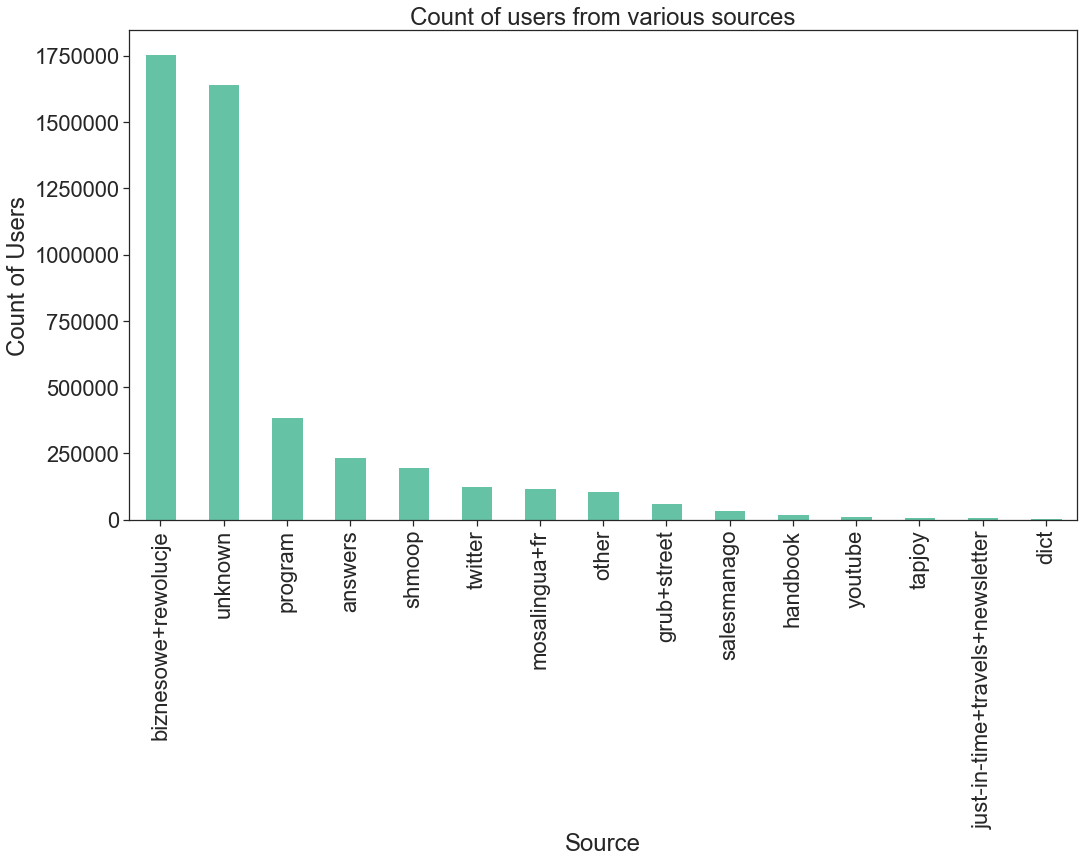

In [126]:
# from which traffic source does the app get its best users and worst users? (in terms of the count of user visits)

ax = data_u.groupby('source')['uid'].count().sort_values(ascending=False).plot(kind = 'bar', 
                                                                             title = 'Count of users from various sources')

ax.set_xlabel('Source')
ax.set_ylabel('Count of Users');

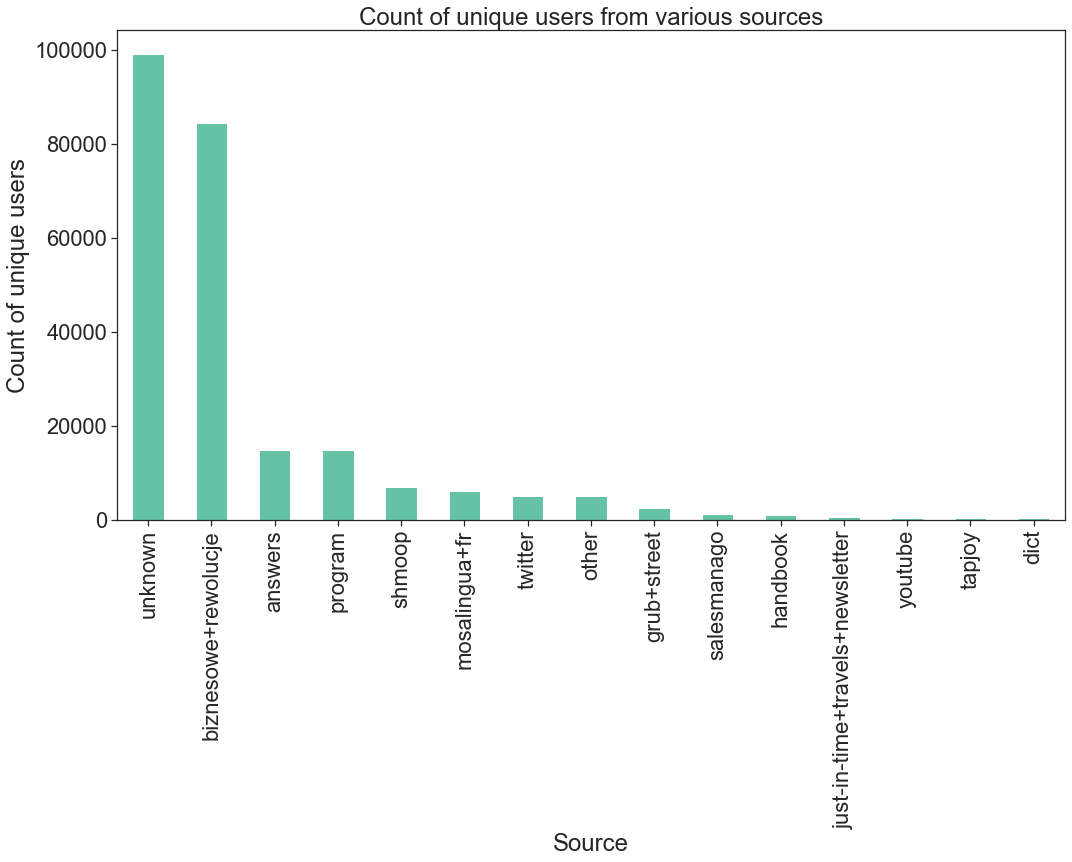

In [128]:
# from which traffic source does the app get its best users and worst users? (in terms of the number of unique users)

ax = data_u.groupby('source')['uid'].nunique().sort_values(ascending=False).plot(kind = 'bar', 
                                                            title = 'Count of unique users from various sources')

ax.set_xlabel('Source')
ax.set_ylabel('Count of unique users');

In [129]:
data_u['source'].unique()

array(['biznesowe+rewolucje', 'program', 'unknown', 'answers', 'shmoop',
       'twitter', 'other', 'mosalingua+fr', 'salesmanago', 'dict',
       'handbook', 'grub+street', 'youtube',
       'just-in-time+travels+newsletter', 'tapjoy'], dtype=object)

In [130]:
pd.DataFrame(data_u.groupby(['source']).nunique()['uid']).sort_values(['uid'])

,uid
source,
dict,327
tapjoy,347
youtube,458
just-in-time+travels+newsletter,509
handbook,1063
salesmanago,1121
grub+street,2430
other,5079
twitter,5134


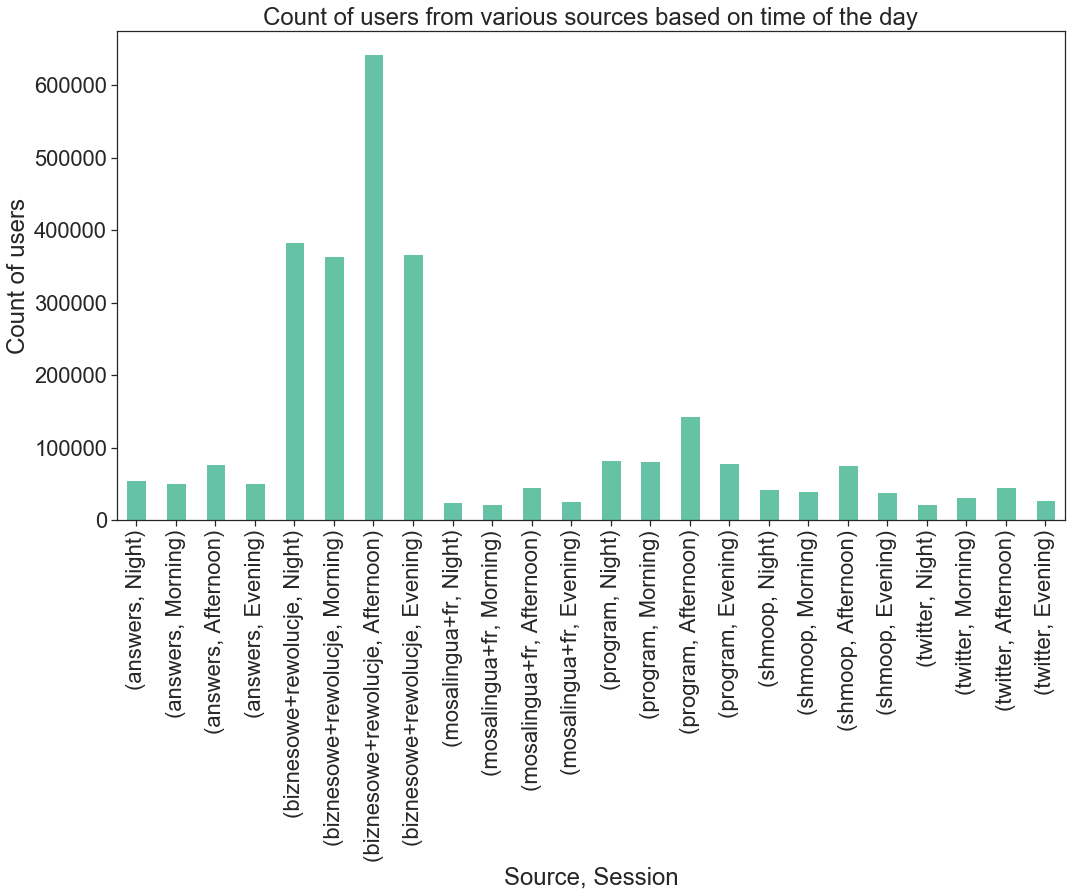

In [131]:
# plotting the count of users for the sources with more than 5000 users per source over different sessions in a day
# the sources considered are biznesowe+rewolucje, answers, program, shmoop, mosalingua+fr, twitter (excluding other and unknown)

ax = data_u[data_u['source'].isin(['biznesowe+rewolucje', 'answers', 'program', 
                    'shmoop', 'mosalingua+fr', 'twitter'])].groupby(['source','session'])['uid'].count().plot(kind = 'bar', 
                    title = 'Count of users from various sources based on time of the day')

ax.set_xlabel('Source, Session')
ax.set_ylabel('Count of users');

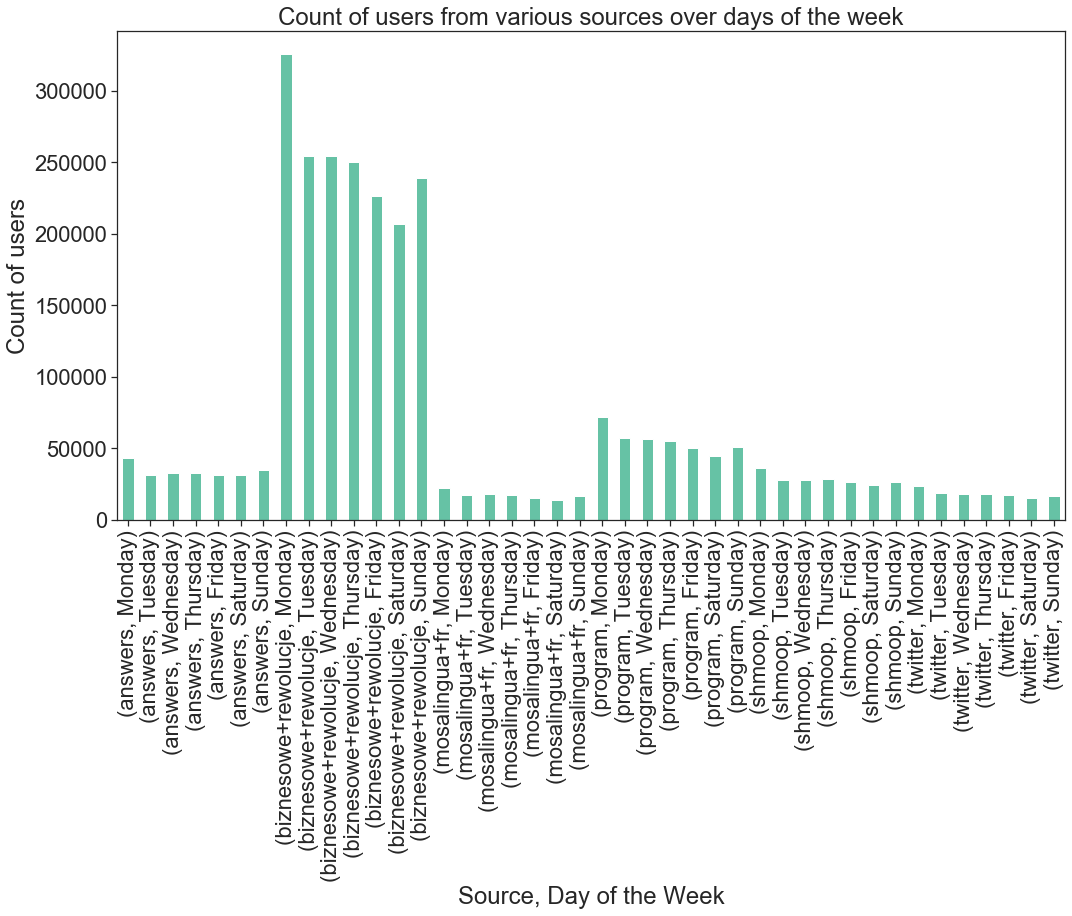

In [132]:
# plotting the count of unique users for the sources with more than 5000 users per source over different days of the week
# the sources considered are biznesowe+rewolucje, answers, program, shmoop, mosalingua+fr, twitter (excluding other and unknown)

ax = data_u[data_u['source'].isin(['biznesowe+rewolucje', 'answers', 'program', 
                    'shmoop', 'mosalingua+fr', 'twitter'])].groupby(['source','dayOfWeek'])['uid'].count().plot(kind = 'bar', 
                                        title = 'Count of users from various sources over days of the week')

ax.set_xlabel('Source, Day of the Week')
ax.set_ylabel('Count of users');

## Insights

From the above bar graphs, on the hindsight, we can see that biznesowe+rewolucje, answers, program, shmoop, mosalingua+fr, twitter (excluding other and unknown) are some the sources that give the most unique users for the app (best sources - in terms of count of user visits and unique users). And sources such as grub+street, dict, tapjoy etc are some of the sources that give the least number of users to the app (worst sources - in terms of count of user visits and unique users).

## Business Recommendation:

1. Based on the above bar graphs, it is clear that biznesowe+rewolucje remains the most prominent traffic source that garners the highest number of users for the app. Hence, we could use this source to publicize latest developments/updates and promotional offers to the app to increase the user attention to the app.
2. Also, it would be useful to collect the data on the amount of time spent on the app by the users coming from different sources to conclusively ascertain which traffic source is the best.
3. A report from the Facebook Quarterly Earning Release ("https://s21.q4cdn.com/399680738/files/doc_financials/2019/Q2/FB-Q2-2019-Earnings-Release.pdf") suggests that almost 94% of Facebook Ad revenue is from mobile apps. Hence, it would be useful to collect the information about the kind of platform the users from different traffic source try to access our app. (Based on the assumption on this data that we do not know the kind of platform users are coming from for this app)

Furthering our analysis, we can calculate total active users per source per date to get some more insights

In [133]:
# total active unique users per source per date.
bysource_bydate= data_u.groupby(['source', 'date']).nunique()['uid']


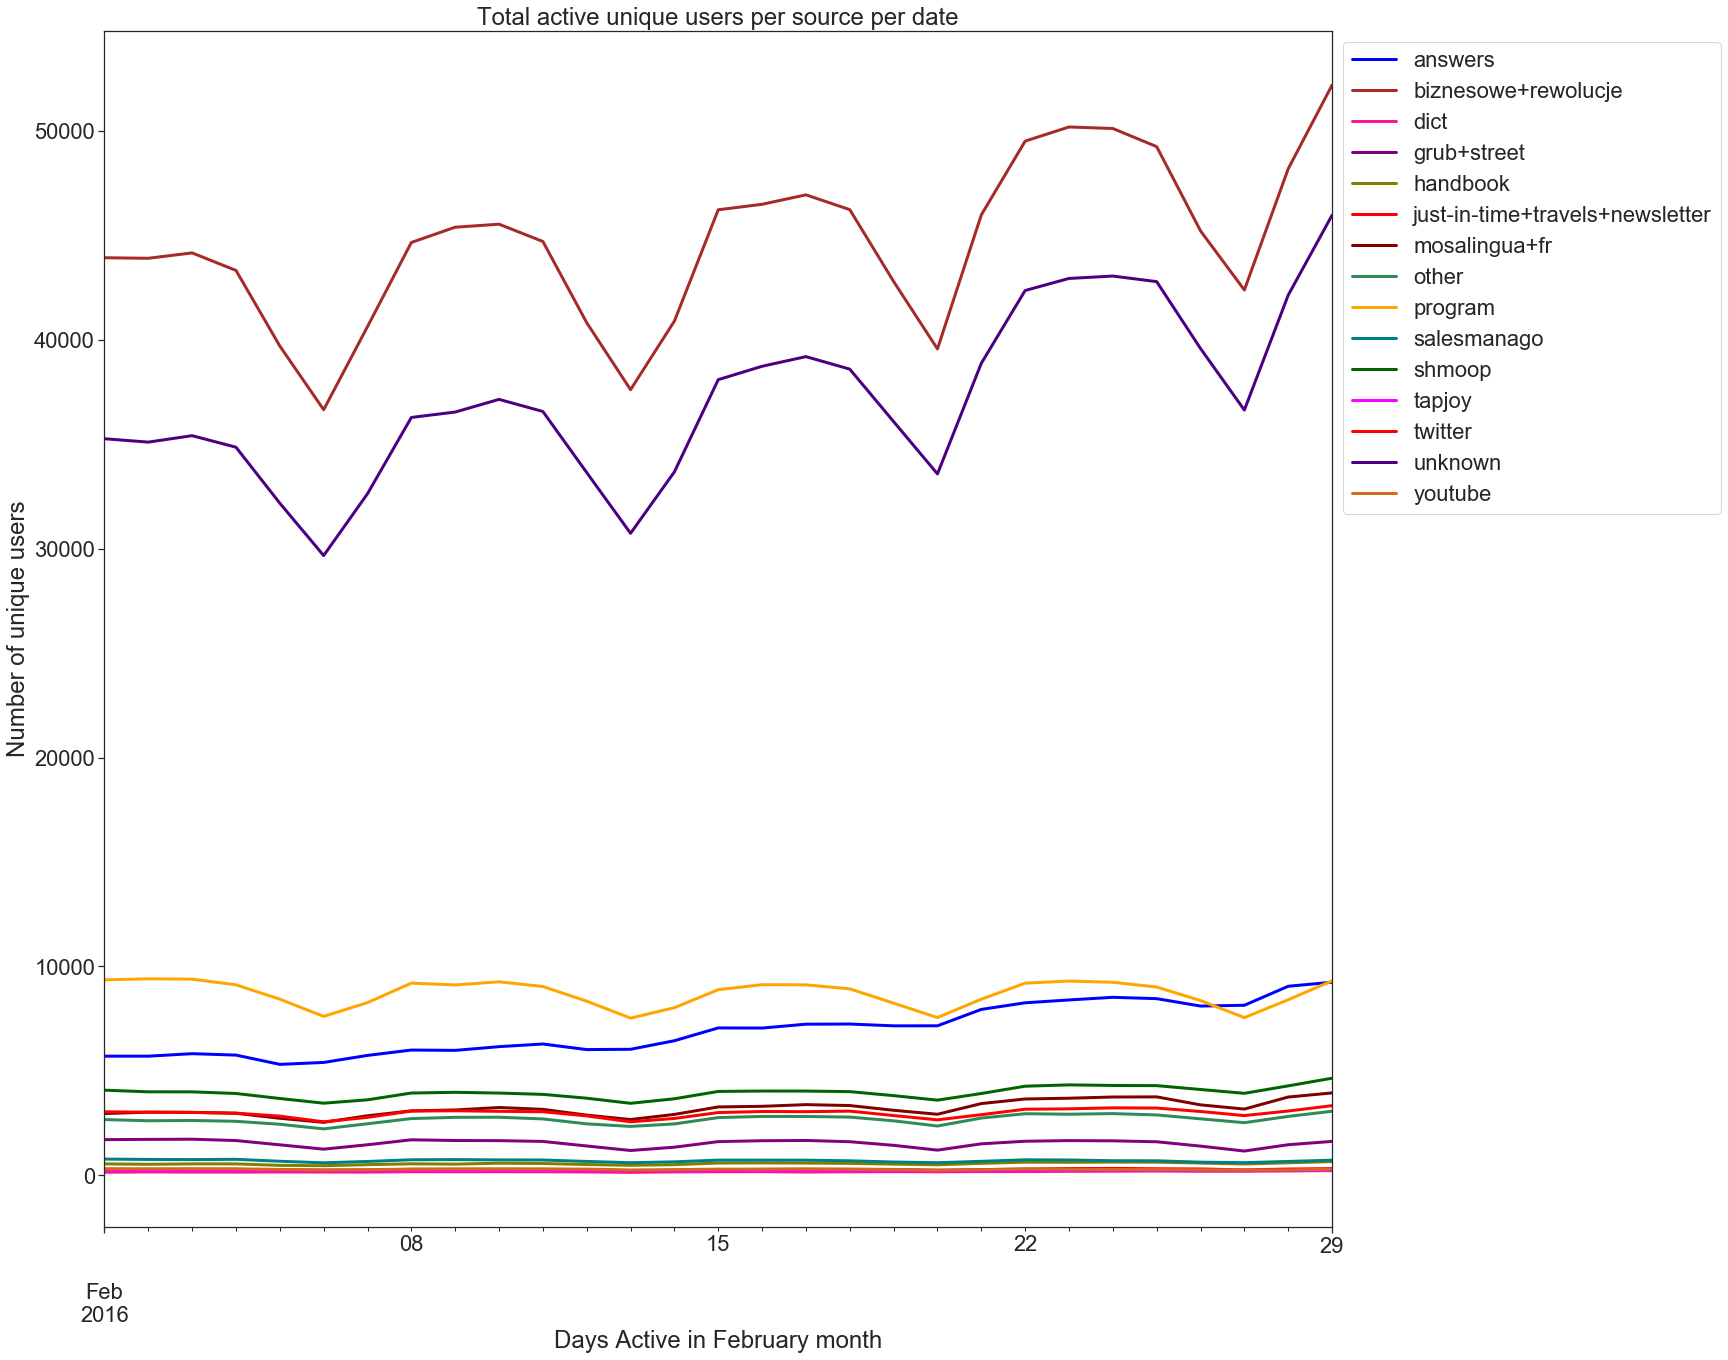

In [134]:
# plot of total active users per source per date

color=['blue', 'brown', 'deeppink', 'purple', 'olive', 'red', 'maroon', 
       'seagreen','orange', 'teal', 'darkgreen', 'magenta', 'red', 'indigo', 'chocolate']
fig, ax = plt.subplots()
bysource_bydate.unstack().T.plot(ax=ax, kind='line',figsize=(22,22), linewidth=3, 
                                 title = 'Total active unique users per source per date',
                                 color=color)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Days Active in February month')
plt.ylabel('Number of unique users');

## Insights

The above line graph shows that the trend of the active users from biznesowe+rewolucje and unknown sources follow the same pettern as the overall Daily Active Users (DAU) graph that we saw earlier. These two sources could have skewed the overall trend line into making us beleive that there are sharp dips during the weekends (especially Saturdays) and a hike at the start of the week (especially Mondays). However, looking at this graph, we can see that some sources that contribute to lesser number of active unique users such as 'answers' doesn't follow this trend.

If total active users per day is the criteria for classifying a source as the best or the worst source, then we could use this line graph in conjunction with the bar graphs to classify a source as the best or the worst source.

## Business Recommendation:

Since the unique users from 'answers' source are steadily increasing (without significant dips like the other two major sources), it would be helpful to analyse the demographic profiles of these users in order to figure out how these users differ with respect to the users from the others sources. We could run an ANOVA test to compare the difference between this group with respect to the other groups to see whether the difference between the groups are statistically significant from one another and make conclusions based on the p-value and a chosen alpha-level. If the Null Hypothesis (H0: No significant difference between groups) gets rejected, then we could try and replicate this trend to the users from other sources as well by doing more research on the demographic and geographic profiles of the users from 'answers'.

In [135]:
# total active days per user per source

bysource_byuid = data_u.groupby(['source','uid']).nunique()['date']
bysource_byuid.unstack().T

source,answers,biznesowe+rewolucje,dict,grub+street,handbook,just-in-time+travels+newsletter,mosalingua+fr,other,program,salesmanago,shmoop,tapjoy,twitter,unknown,youtube
uid,,,,,,,,,,,,,,,
007lqy8pw8PF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
008wXBXcFOF5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00BBLeYvGxwU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
00Dd47PrCevO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
00FhDR8eh9W0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzthHMIMI343,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzuR9bBBHx25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
zzumW4FgVkVY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN


We could also use KDE plot to estimate the probability density function of the total active days per source per user in a non-parametric way (i.e. by not making any assumptions about the underlying distributions for our data). We shall be adding a kernal centered about each data point for every single data point under consideration and eventually add these up to get closer to the probability density function thereby arriving at the kernel density estimation.

In [136]:
# count of users per source

pd.DataFrame(data_u.groupby(['source']).count()['uid']).sort_values(['uid'])

,uid
source,
dict,6247
just-in-time+travels+newsletter,11506
tapjoy,11517
youtube,13679
handbook,21055
salesmanago,37690
grub+street,61077
other,109866
mosalingua+fr,121107


In [137]:
# count of unique users per source

pd.DataFrame(data_u.groupby(['source']).nunique()['uid']).sort_values(['uid'])

,uid
source,
dict,327
tapjoy,347
youtube,458
just-in-time+travels+newsletter,509
handbook,1063
salesmanago,1121
grub+street,2430
other,5079
twitter,5134


From the above summary statistics, it is also visible that some sources like youtube, program etc have a better ratio of active users per unique users than some of the other sources such as just-in-time+travels+newsletter and hence could be considered as better sources.

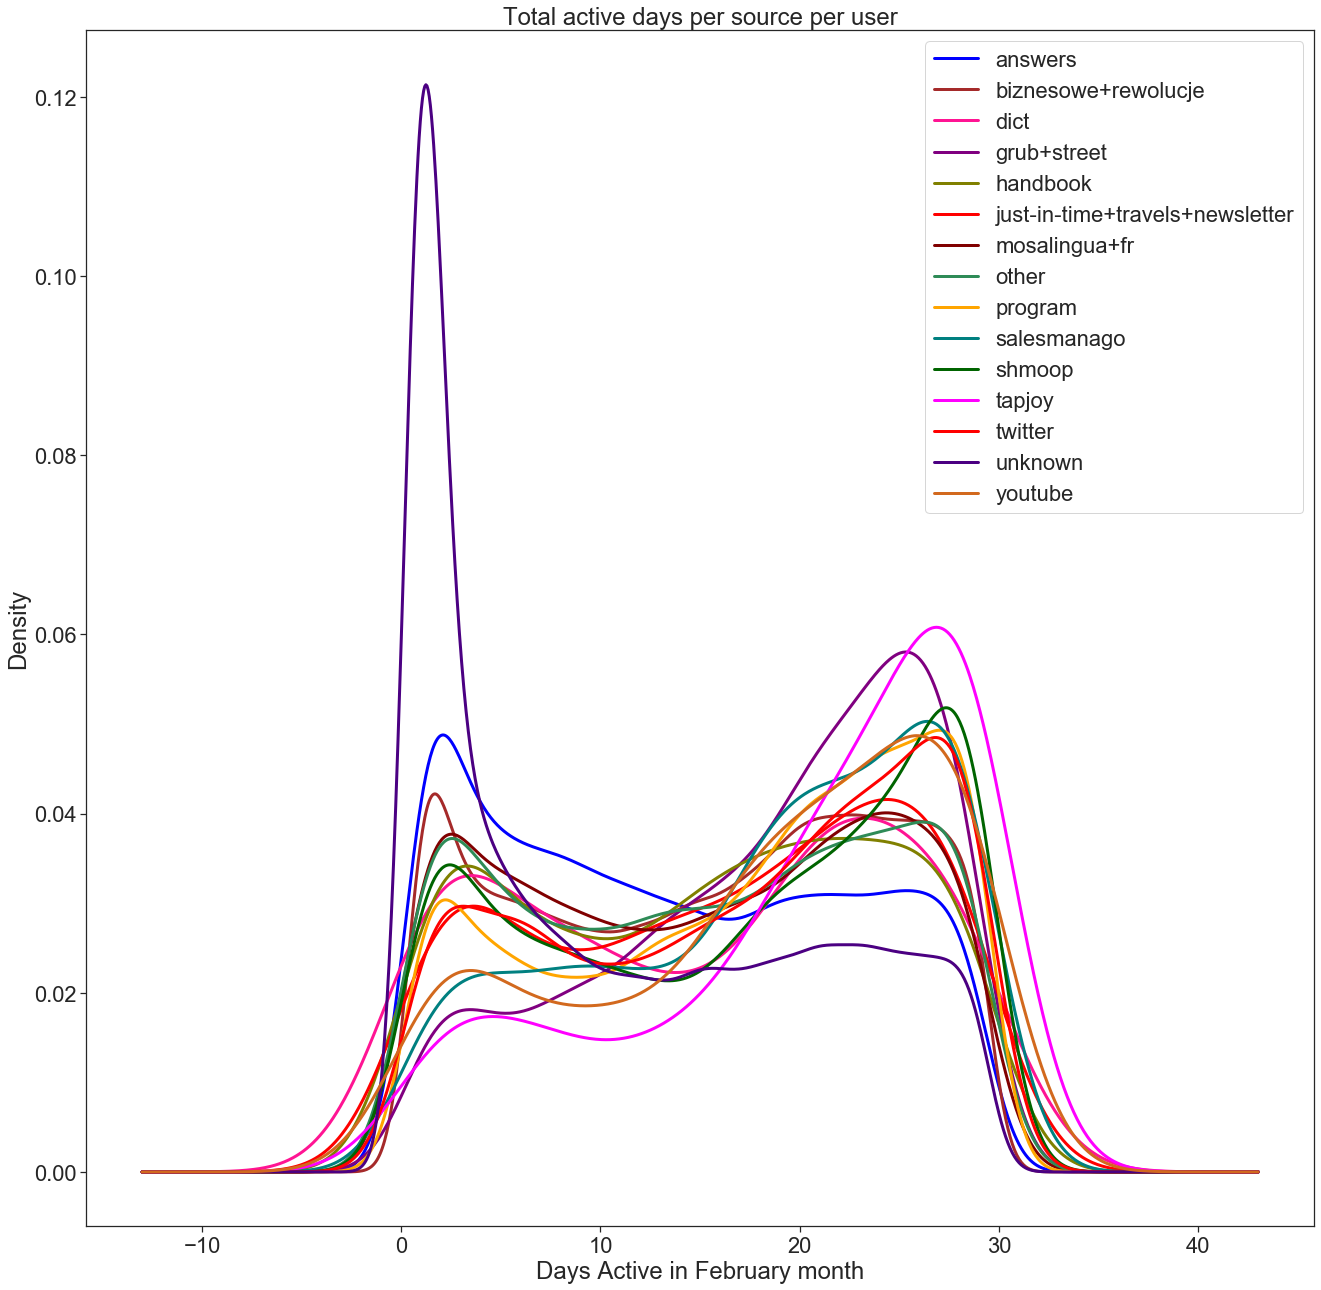

In [138]:
# plot of total active days per source per uid

color=['blue', 'brown', 'deeppink', 'purple', 'olive', 'red', 'maroon', 
       'seagreen','orange', 'teal', 'darkgreen', 'magenta', 'red', 'indigo', 'chocolate']
fig, ax = plt.subplots()
bysource_byuid.unstack().T.plot(ax=ax, kind='kde',figsize=(22,22), linewidth=3, 
                                 title = 'Total active days per source per user',
                                 color=color)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Days Active in February month')
plt.ylabel('Density');

## Insights

I grouped the source, uid and counted the number of unique dates. We may use a KDE plot to project the number of days a user was active per source.

This KDE plot is an estimation the probability density function of the total active days per source per user. Best traffic sources are the ones with peak at the end of the month and the worst traffic sources are the ones with the peak at the beginning of the month. From the above KDE plot, we can see that many people started using the app at the beginning but only a few of them remained regular users of the app through-out the month of February (like how we saw earlier in the cohort analysis).

However, using this KDE plot, we can see that the sources Grub+Street and tapjoy have the mode at around the 28th and 29th day respectively which means that most of the users from these sources have used the app for almost the whole month of February. This KDE plot shows that the 'unknown' sources are the worst sources with mode of 0 despite getting most users. And, contrary to what we found in the prior line graph where the sources 'biznesowe+rewolucje' and 'answers' had a lot of unique users per day, this KDE plot shows that the number of days users from this source used the app is less.   

Hence, we could say that if the criteria for classification of a source as best or worst is based on the number of days the users from a particular source were active for the month, then we could use this KDE plot.


## Business Recommendation:

Although the number of unique users from Grub+Street and tapjoy are relatively less (2430 and 347 respectively), the users from these souces seem to be more loyal than the users from the other sources in using the app regularly for a longer period of time. Repeated visits and loyalty to an app is the key for an enormous success. And these smaller sources are often overlooked in the analysis, but I believe that there is a huge potential waiting to be tapped. If it were me, I would look into analyzing more on what makes people from these sources use the app for a longer period of time than the users from other sources.

And, shmoop seems to be a clear winner when it comes to the best source, since it has 6889 unique visitors with 198356 app user visits and also the users of this source seem to use the app for the maximum amount of time. This could be followed by twitter, program, grub+street and tapjoy. If we are starting a referral campaign where the user gets rewards when the person he referred to joins the app, these sources are the best places to start.

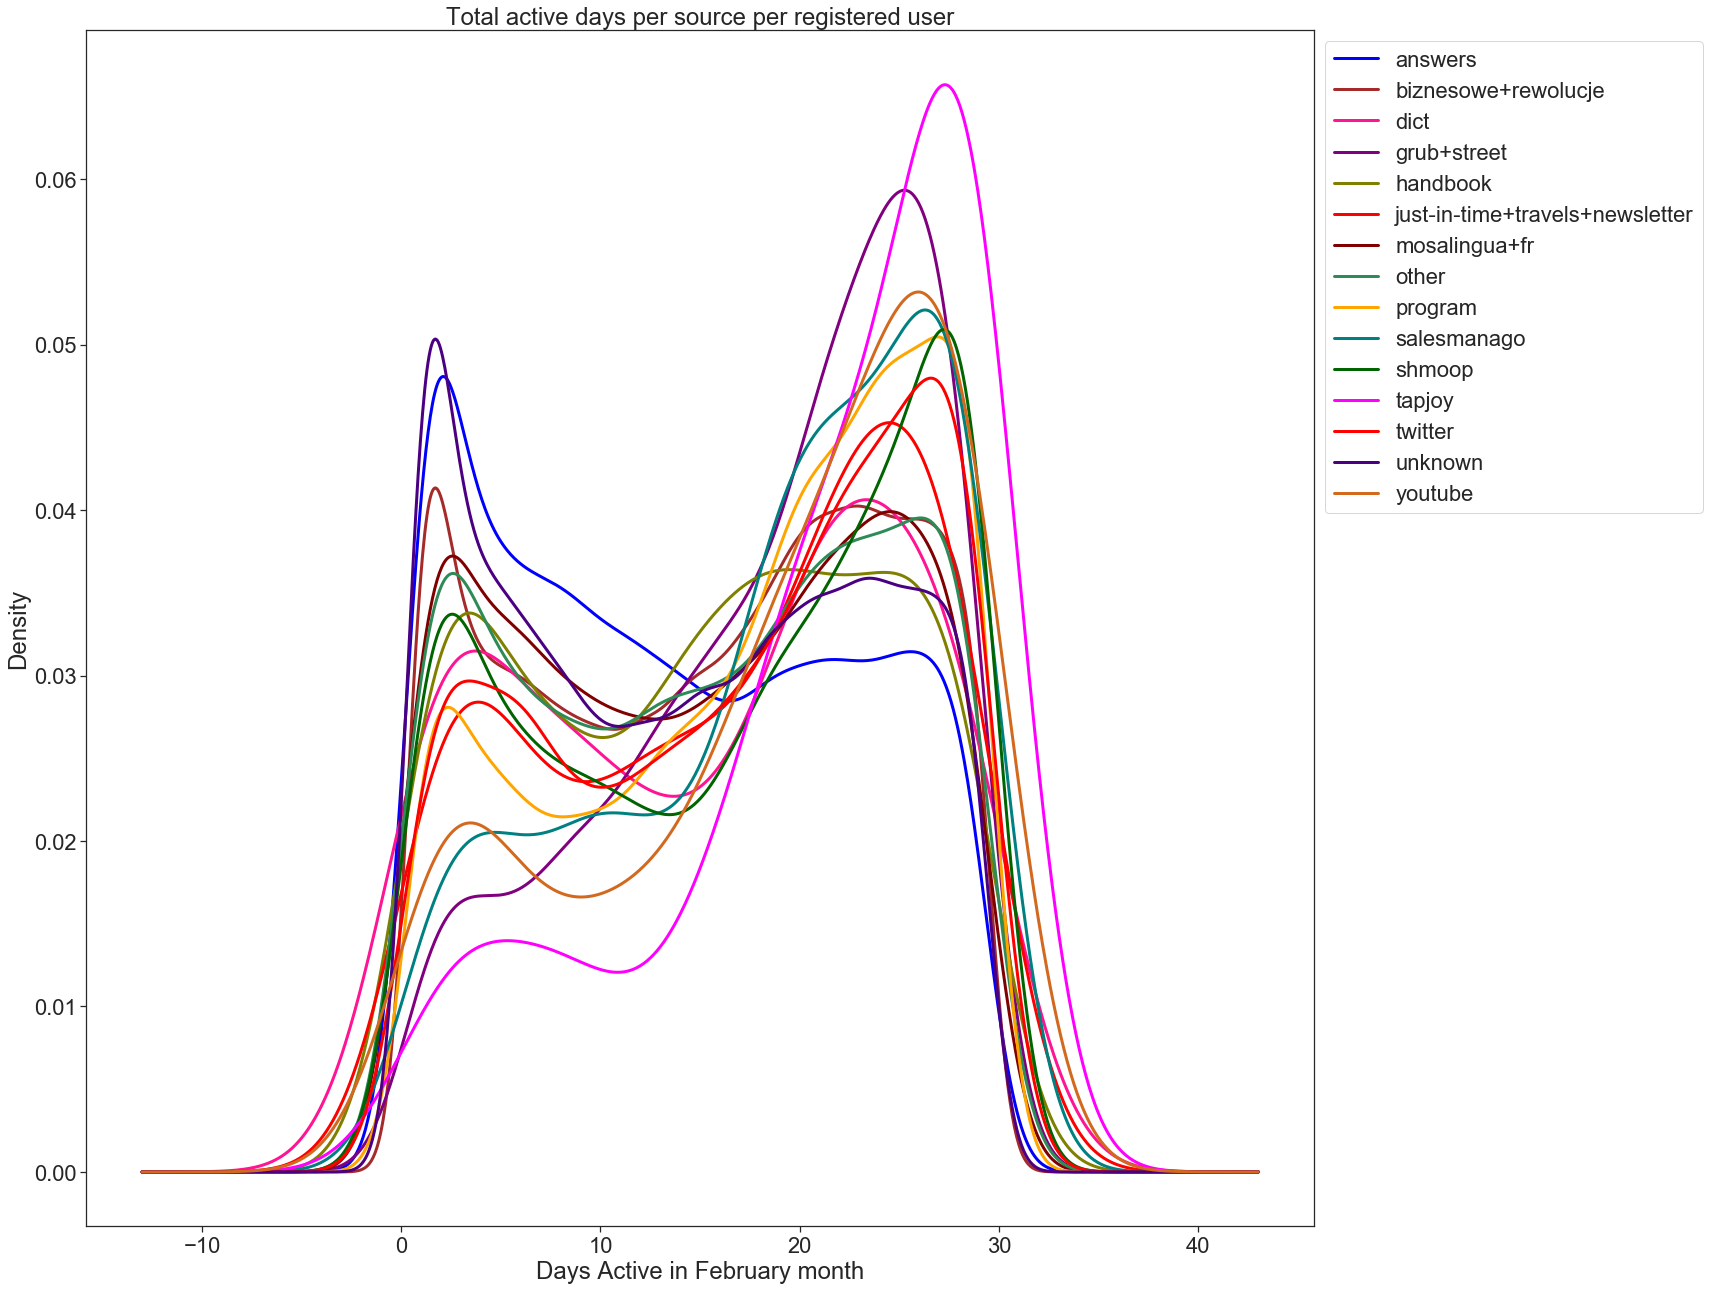

In [139]:
# total active days per user per source

bysource_byuid_reg = data_u[data_u['registered'] == 1].groupby(['source','uid']).nunique()['date']

color=['blue', 'brown', 'deeppink', 'purple', 'olive', 'red', 'maroon', 
       'seagreen','orange', 'teal', 'darkgreen', 'magenta', 'red', 'indigo', 'chocolate']
fig, ax = plt.subplots()
bysource_byuid_reg.unstack().T.plot(ax=ax, kind='kde',figsize=(22,22), linewidth=3, 
                                 title = 'Total active days per source per registered user',
                                 color=color)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Days Active in February month')
plt.ylabel('Density');

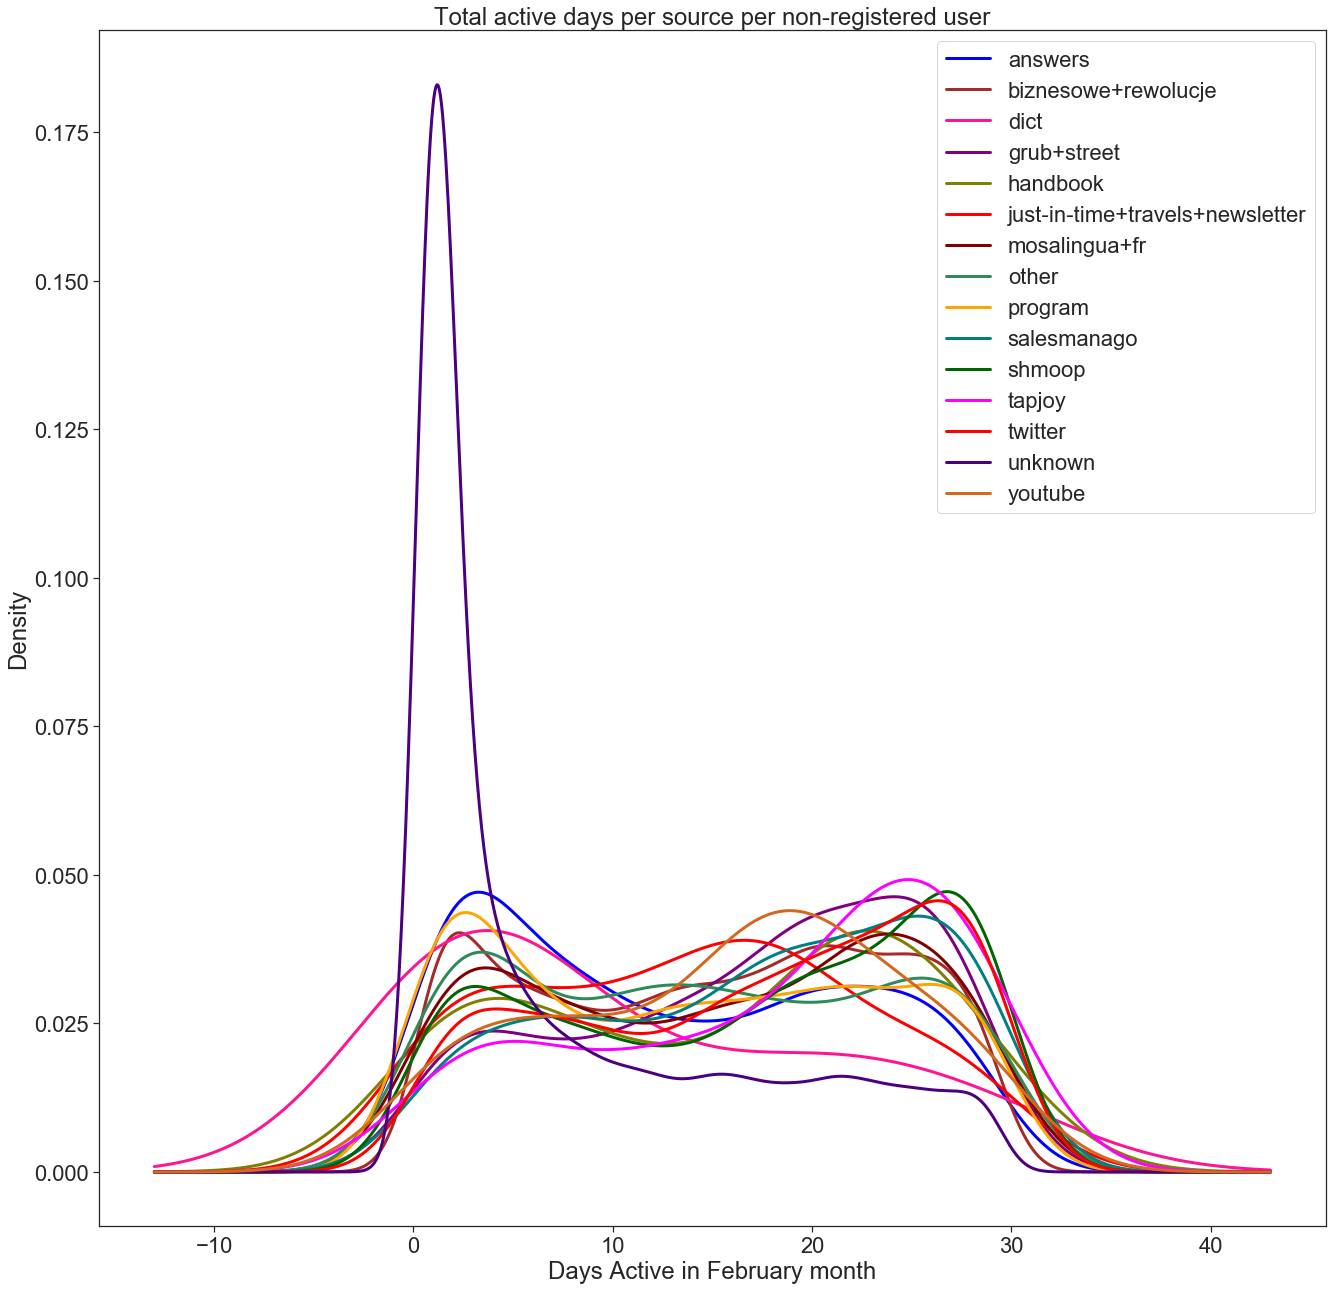

In [140]:
bysource_byuid_unreg = data_u[data_u['registered'] == 0].groupby(['source','uid']).nunique()['date']

color=['blue', 'brown', 'deeppink', 'purple', 'olive', 'red', 'maroon', 
       'seagreen','orange', 'teal', 'darkgreen', 'magenta', 'red', 'indigo', 'chocolate']
fig, ax = plt.subplots()
bysource_byuid_unreg.unstack().T.plot(ax=ax, kind='kde',figsize=(22,22), linewidth=3, 
                                 title = 'Total active days per source per non-registered user',
                                 color=color)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Days Active in February month')
plt.ylabel('Density');

## Insights

Based on the above two KDE plots for registered and non-registered users, we can see that for registered users the second mode (near the end of the month) is higher than the first mode (at the beginning of the month). This is expected considering that a registered user is more likely to continue using the app for a longer period of time than a non-registered user.

## Business Recommendation

We can also notice that most of the users for the Grub+Street and tapjoy who used the app for a longer period of time are registered users. Hence, it would be good to look into ways of converting non-registered users from these sources into registered users by offering sign-up incentives.

# Separate from the data analysis, it would be great to hear your thoughts on the Grammarly product and what data-related projects/ideas you think we should be pursuing.

I have been using Grammarly for over 2 years now and I got to say Grammarly has been immensely helpful in improving my quality of writing in many ways. Thank you, Grammarly!



## Marketing recommendation

Since, I am a student at Iowa State University, I enjoy a Premium package of Grammarly as a part of the Premium subscription given to us from the Graduate College. However, I was looking into the pricing for Grammarly and noticed that it is currently at $139.95/year for just one user. I believe that introducing a 'Family Plan' model for a group of 2 or 3 users would attract more number of people willing to purchase the Premium package of Grammarly.

Especially in the time of a pandemic with millions of families purchasing laptops and tablets for their children to use for shcooling at home, a plan like this would have a high chance of clicking. If we could find a way to wrap this technology around to help the kids improve their English writing skills at home in their comfort zone, parents would be more than willing to give it a shot. We may even spin it as 'One less thing parents have to help their children with'


## Improved suggestions on punctuations

I just typed in the following two sentences in Grammarly

### It was three of us who went to the movie; John, David, and myself.
### It was three of us who went to the movie, John, David, and myself.

However, for both the sentences Grammarly gave me a feedback saying "Looking good!" <br>
The "Clarity" parameter in Grammarly discerns this as "Very clear". In my opinion, this could be a case for ambiguity. If some additional information could be provided on when exactly to use what kind of punctuations ("," or ";" in this example), that would be more helpful to the users. This could be incorporated as a small pop-up that show up when we hover over the punctuations.

## Name: Kishor Kumar Sridhar
## Email: kishorkumarsridhar@gmail.com